<a href="https://colab.research.google.com/github/akash1003/Image-Compression-Using-SVD/blob/main/RANSAC_for_Robust_2D_Homography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RANSAC Implementation

Implementing the RANSAC algorithm to reject outliers and build a more robust 2D homography. It will be build around the basic 4-point homography based on the Direct Linear Transform (pg 91, Algorithm 4.1, Hartley-Zisserman Text on Multi-view Geometry).

The task is to obtain the homography of a 2D polygonal plate with 12 sides and its image in a camera. The plate and camera are arbitrarily oriented in 3D space (but orientation is fixed).

The vertices of the plate and its image form the point correspondences for the homograpy. However, we intentionally introduce large noise in a few of the correspondences, to test the efficacy of the RANSAC approach to overcome/reject these.

Comparing homography with that provided by openCV across a range of outlier probabilities.

In [ ]:
# Package for numerical linear algebra computations
import numpy as np

#open CV library for image and video manipulation
import cv2 as cv

# package for plotting graphs
import matplotlib.pyplot as plt

# This library has a useful set of fuctions to implement rotations
# via matrices, quaternions, euler angles etc and enables conversion across
# these formats.
from scipy.spatial.transform import Rotation as R 

# This package provides all the necessary functions to manipular and 
# work on points, lines, planes and conics, in both 2D and 3D projective
# geometry framework
!pip install geometer
import geometer as pg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.2 MB/s 


In [ ]:
# test out the rotation  function of scipy.spatial.transform package

# implement a rotator which provides rotation of 90deg
# counter clock wise (CCW) about an axis [0,0,1]
# orientation of rotation is when looking down into the axis
# direction
r = R.from_rotvec(np.pi/4 *np.array([0,0,1])) ## CCW looking down from the arrow tip
v = np.array([1,1,1])
print(r.as_matrix(), "vector ", v, "is rotated to:", r.apply(v))

[[ 0.70710678 -0.70710678  0.        ]
 [ 0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]] vector  [1 1 1] is rotated to: [-1.11022302e-16  1.41421356e+00  1.00000000e+00]


In [ ]:
# test out the rotation function of geometer packacge
# a 3D direction vector is represented as a ideal point
# or a point at infinity in homogenous
axis = pg.Point([0,0,1,0])

#note that orientation of rotation for same angle, axis based
# representation is opposite to that by scipy above.

geometer_rt = pg.rotation(np.pi/4,axis=axis) #CW looking down from the arrow tip
p = pg.Point([1,0,1,1])
print("rotating point ",p, " CW by 90 clockwise using geometer:", geometer_rt.apply(p))
scipy_rt = pg.affine_transform(r.as_matrix(),[0,0,0])
print("rotating piont ",p, " CCW by 90 clockwise using scipy:",scipy_rt.apply(p))


rotating point  Point(1, 0, 1)  CW by 90 clockwise using geometer: Point(0.7071067811865476, -0.7071067811865475, 1.0)
rotating piont  Point(1, 0, 1)  CCW by 90 clockwise using scipy: Point(0.7071067811865475, 0.7071067811865476, 1.0)


In [ ]:
#utility function to get the in-homogenous cordinates 
#by dividing by the last coordinate value of the homogenous representation
def InHomogenize (v,tol=1e-3):
  '''Convert to inhomogenous coordinates.
     input: v, nxm array, with last column used for homogenization
            m is 3 or 4 for 2D or 3D
  '''
  if len(v.shape) > 2 :
    raise Exception("Sorry - only upto 2-D arrays allowed")
  z = v[...,-1] #last coordinate
  return np.divide(v.T, np.where(np.abs(z)> tol,z,1)).T

In [ ]:
InHomogenize(np.array([[2,3,2.],[4,5,8.],[6,6,6.],[8,9,10.]]))

array([[1.   , 1.5  , 1.   ],
       [0.5  , 0.625, 1.   ],
       [1.   , 1.   , 1.   ],
       [0.8  , 0.9  , 1.   ]])

In [ ]:
#camera parameters for the camera used in imaging the plate
# same camera as in the last lab
#(from: https://github.com/opencv/opencv/blob/3.4/samples/data/left_intrinsics.yml)
#intrinsic parameters 
cameraMatrix = np.array(
    [
      [5.3591573396163199e+02, 0., 3.4228315473308373e+02,],
      [0.,5.3591573396163199e+02, 2.3557082909788173e+02],
      [0.,0.,1.]
    ]
)
#distortion coefficients
distCoeffs=np.array(
    [-2.6637260909660682e-01, -3.8588898922304653e-02,
       1.7831947042852964e-03, -2.8122100441115472e-04,
       2.3839153080878486e-01]
)

In [ ]:
class Plate:
  '''
  2 Dimensional polygonal plate with nSides and radius
  represented in 3D homogenous coordinates
  '''
  def __init__(self, nSides=6, radius=5.0, location=[0,0,0], angle=0, axis=[0,0,1]):
    '''
    nSides : number of sides of plate
    radius: distance of each vertex form centroid
    location: 3D location of centroid (inhomogenous coordinates)
    angle: in radians of CCW rotation about axis
    axis: 3D axis of rotation
    '''
    self.nSides = nSides
    self.radius = radius
    self.pts = np.ones((nSides,4), dtype=np.float32)
    idx = np.arange(0,nSides)
    self.pts[:,0] = radius*np.cos(idx*np.pi*2/nSides)
    self.pts[:,1] = radius*np.sin(idx*np.pi*2/nSides)
    self.pts[:,2] = 0
    self.pts_coll = pg.PointCollection(self.pts)
    self.pose = pg.affine_transform(R.from_rotvec(angle*np.array(axis)/np.linalg.norm(axis)).as_matrix(),location)
    
  def setPose(self,location=[0,0,0], angle=0, axis=[0,0,1]):
    self.pose = pg.affine_transform(R.from_rotvec(angle*np.array(axis)/np.linalg.norm(axis)).as_matrix(),location)

  def vertices_3D(self):
    '''
    vertex points in 3D as per the plate's pose
    '''
    dis_pts = self.pose.apply(self.pts_coll)
    return(dis_pts.normalized_array[:,:-1])

  def image_the_points(self, camera_pose, camera_matrix):
    '''
    camera_pose: 3D pose as geometer.affine_transform
    camera_matrix: 3x3 matrix
    returns the plates points projected onto camera's image plane
    '''
    plate_pts = self.pose.apply(self.pts_coll)
    #print("plate_pts=",plate_pts)
    plate_in_camera_pose_pts = camera_pose.inverse().apply(plate_pts)
    #print("plate_in_camera_pose_pts=",plate_in_camera_pose_pts)
    plate_norm_pts = plate_in_camera_pose_pts.normalized_array[:,:-1] #in 3D inhomogenous
    #print("plate_norm_pts=",plate_norm_pts, plate_norm_pts @ camera_matrix.T)
    img_coord = InHomogenize(plate_norm_pts @ camera_matrix.T)
    return(img_coord[:,:2])

In [ ]:
def givePoseTransform(location=[0,0,0], angle=0, axis=[0,0,1]):
  '''Given the angle, axis of rotation and location (translation)
      construct the affine transform matrix
  '''
  return(pg.affine_transform(R.from_rotvec(angle*np.array(axis)/np.linalg.norm(axis)).as_matrix(),location))


In [ ]:
#create and image the plate
plate = Plate(nSides=12, radius=5)
#print(plate.pts)
plate.setPose(location=[0,0,28],angle=np.pi/4, axis=[0,1,1])
#print(plate.vertices_3D())
camera_pose = givePoseTransform(location=[0,0,0],angle=0,axis=[0.0,0,1])
img_pts=plate.image_the_points(camera_pose,cameraMatrix)
#print("img_pts=",img_pts)
dis_pts = img_pts.astype(int)


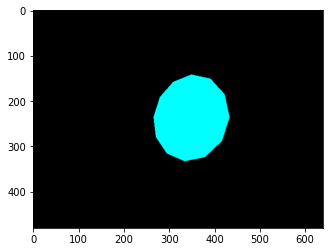

In [ ]:
dimg = np.zeros((480,640,3),np.uint8)
cv.fillPoly(dimg,pts=[dis_pts],color=(0,255,255))
plt.imshow(dimg)

In [ ]:
def CalcHomographyErr (
    H, #homography matrix
    src_pts, #src points
    dst_pts, #dst points for calculating error
  ):
  ''' Calculate the homography error via the euclidean distance between 
  homographed points and their corresponding companion point 
  '''
  img_fromhom_pts = InHomogenize((H @ src_pts.T).T)[:,:2].astype(int)
  return(np.linalg.norm(img_fromhom_pts-dst_pts))

In [ ]:
def ImageHomographyPlate (
    H,  #homography matrix
    src_pts,   #vertices of source plate
  ):
  '''Image the homographed plate
  '''
  img_fromhom_pts = InHomogenize((H @ src_pts.T).T)[:,:2].astype(int)
  dimg = np.zeros((480,640,3),np.uint8)
  cv.fillPoly(dimg,pts=[img_fromhom_pts],color=(0,255,255))
  plt.imshow(dimg)

In [ ]:
#Compute ideal homography between noiseless correspondence pairs of the plate
srcPts = np.ones((plate.pts.shape[0],3))
srcPts[:,:2] = plate.pts[:,:2]
Hideal,mask = cv.findHomography(srcPts[:,:2],img_pts)
print("mean RMS error with no noise is =", CalcHomographyErr(Hideal,srcPts, img_pts))

mean RMS error with no noise is = 2.6304612068776714


In [ ]:
def GenNoisySourcePts (
    p, #outlier probability
    inlier_std, #standard deviation for inliers
    outlier_std, #standard deviation for outlier
    srcPts,  #source pts to which bi-modal noise is added
    seed=345, #seed for random generatr
  ):
  '''
  Generate source points with some outliers - via bi-modal gaussian distribution
  '''
  rng = np.random.default_rng(seed)
  #create an array of std deviations of the size of the src pts
  #with either inlier or outlier std deviation. 
  #use same std deviation for both coordinates
  v = srcPts[:,:2]
  y=np.zeros(v.shape)
  y[:,0]=rng.choice([inlier_std,outlier_std],size=srcPts.shape[0],p=[1-p,p])
  y[:,1] = y[:,0] #copy the same std for the other coordinate
  #print(y)
  #generate this bi-modal normal noise vector to add to the coordinates
  z = rng.normal(0,y,v.shape)
  #now generate noisy source points with some outliers
  noisy_src_pts = np.ones((srcPts.shape[0],3))
  noisy_src_pts[:,:2] = v + z
  return (noisy_src_pts)

In [ ]:
#generate noisy source and image points by adding zero-mean gaussian noise to each
rng1 = np.random.default_rng(123)
img_noise_std = 1 #in pixels std deviation of noise in image
#now generate noisy image points (unimodal gaussian noise)
noisy_img_pts = img_pts+rng1.normal(0,img_noise_std,img_pts.shape)


In [ ]:
outlier_prob = 0.5 #probability of an outlier point for the noisy src
inlier_std = 0.1  #std deviation of inlier point for noisy src
outlier_std = 5  #std deviation of outlier point for noisy src
seed = rng1.integers(25) 
noisy_src_pts = GenNoisySourcePts(outlier_prob, inlier_std, outlier_std, srcPts,seed=seed)

Without RANSAC: RMS error (in pixels) =  141.79042857232022


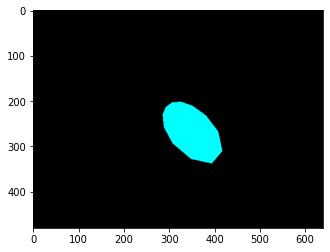

In [ ]:
#without RANSAC
Hnoransac,mask = cv.findHomography(noisy_src_pts,
                            noisy_img_pts, 
                            method=0,
                            )
print("Without RANSAC: RMS error (in pixels) = ",
      CalcHomographyErr(Hnoransac, srcPts, img_pts))
ImageHomographyPlate(Hnoransac, srcPts)


Let $(x_{i1},x_{i2},1), (y_{i1},y_{i2},1)$ be the corresponding point pairs linked by homography H:

$
H = \begin{bmatrix}
h_{11} & h_{12} & h_{13} \\
h_{21} & h_{22} & h_{23} \\
h_{31} & h_{32} & h_{33} \\
\end{bmatrix} = 
\begin{bmatrix}
h_1^T\\
h_2^T\\
h_2^T\\
\end{bmatrix}
$

and, 
$
\begin{bmatrix}
k*y_{i1} \\
k*y_{i2} \\
k \\
\end{bmatrix} = H \begin{bmatrix}
x_{i1} \\
x_{i2} \\
1 \\
\end{bmatrix}
$
for arbitrary scalar k

This gives two equations per point (eliminating k ):

$
y_{i1} = \frac{h_{11} x_{i1}+h_{12} x_{i2}+h_{13}}{h_{31}x_{i1}+h_{32}x_{i2}+h_{33}}
$

$
y_{i2} = \frac{h_{21} x_{i1}+h_{22} x_{i2}+h_{23}}{h_{31}x_{i1}+h_{32}x_{i2}+h_{33}}
$


The above contributes two rows to the matrix 2n x 9 sized matrix $A$
where n is the number of point pairs and :

$
A * \begin{bmatrix} 
h_1 \\ 
h_2 \\ 
h_3 \\ \end{bmatrix} = 0
$ 

Thus the homography H's columns, when stacked up as a single 9x1 column vector, is the null space of A

The null space of A can be obtained via SVD decomposition of A and the right sigular vectors corresponding to the '0' singular value form the basis of the null space.

$ svd(A) = U \Sigma V^T$

In this case, for a four point homography (n=4), rank(A)=8 and V is 9x9 orthogonnal matrix and the last singular vector V[9] is the homography matrix. 


In [ ]:
def OurHomography(
    s, #array of four homogenous 2D points
    d, #array of four corresponding destination 2D points
  ):
  '''
  Four point homography using direct linear transform
  '''
  A = np.zeros((2*s.shape[0],9))
  for i in range(s.shape[0]):
    A[2*i,0:3] = s[i,:]
    A[2*i,6:9] = -d[i,0]*s[i,:] 
    A[2*i+1,3:6] = s[i,:]
    A[2*i+1,6:9] = -d[i,1]*s[i,:]    

  #now need to find the null space of this matrix
  U, s, VT = np.linalg.svd(A)
  H = VT[-1,:].reshape(3,3)
  return(H)

With four point, RMS Error= 2.6304612068776714


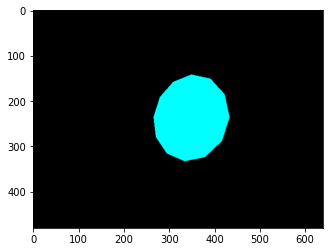

In [ ]:
# test out four point homography from above by applying on
# first four pairs of points from noiseless source and image points
Hfour = OurHomography(srcPts[0:4],img_pts[0:4])
print("With four point, RMS Error=", CalcHomographyErr(Hfour, srcPts, img_pts))
ImageHomographyPlate(Hfour, srcPts)

In [ ]:
#Your RANSAC algorithm
#<MODIFY THIS CELL>
def RansacHomography (
      noisy_src_pts,               #source points
      noisy_img_pts,               #image points
      ransac_threshold,            #Error threshold to check for inliers to a model
      nSamples = 40,               #number of random sample sets to try
      minNumInliersThreshold=0.8,  #percentage of points needed to support so that we can stop the search
    ):
  nPts = 4 #number of points needed for a 2D homography computation
  bestInlierNum = 0
  bestInlierIdxSet = []
  rng1 = np.random.default_rng(345)
  #print(noisy_src_pts)
  for i in range(nSamples):  #do this upto nSamples times 

    #get a random subset of four points from the list of point pairs
    #by picking the four indices of these point pairs
    idx = rng1.choice(np.arange(noisy_img_pts.shape[0]),size=nPts,replace=False)

    #find the homography using these four points
    Hn = OurHomography(noisy_src_pts[idx],noisy_img_pts[idx])
    #find the number of inliers
 
    #now find the inlier points which match this model and keep
    #track of the best model so far
    nInliers = 0
    inlierIdxSet = []

    #iterate through all the point pairs to check if they are an inlier to this model
    for i in range(noisy_src_pts.shape[0]):
      #use the homography to compute the image point from the source point
      img_fromhom_pt = InHomogenize((Hn @ noisy_src_pts[i,:].T))[:2]
      #check if the distance of the homographed point is within threshold of image point
      #<YOUR CODE HERE>
      ####################3print("i am here",noisy_img_pts[i].shape)
      err=CalcHomographyErr(Hn, noisy_src_pts[i].reshape(1,3), noisy_img_pts[i])
      if err < ransac_threshold:
        nInliers=nInliers+1
        inlierIdxSet.append(i)
    #end for i

    if (nInliers > bestInlierNum) :
      #<YOUR CODE HERE>
      # this is a better model than what we had so far - 
      # keep track of the inlier indices
      bestInlierNum=nInliers
      bestInlierIdxSet=inlierIdxSet
      if nInliers > minNumInliersThreshold * noisy_src_pts.shape[0] :
        #got enough inliers - stop the search for any additional models
        break

  #recalculate the homography using all the inlier point pairs
  Hbest = OurHomography(noisy_src_pts[bestInlierIdxSet,:], 
                                noisy_img_pts[bestInlierIdxSet,:]
                                )
  img_fromhom_pts = InHomogenize((Hbest @ noisy_src_pts[bestInlierIdxSet].T).T)[:,:2]
  return (Hbest)

In [ ]:
print(bestInlierNum)

With our RANSAC, RMS Error= 190.5887725268026


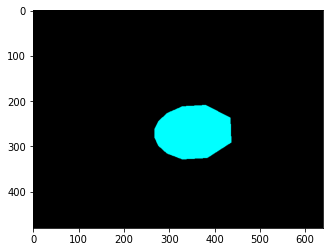

In [ ]:
Hransac = RansacHomography(noisy_src_pts, noisy_img_pts, ransac_threshold=10,nSamples=200)
print("With our RANSAC, RMS Error=", CalcHomographyErr(Hransac, srcPts, img_pts))
ImageHomographyPlate(Hransac, srcPts)

With openCV RANSAC: RMS Error =  235.40961684119108


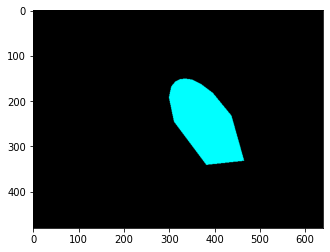

In [ ]:
#Use OpenCV's RANSAC
Hopencv, mask = cv.findHomography(noisy_src_pts,
                                  noisy_img_pts,
                                  method=cv.RANSAC,
                                  ransacReprojThreshold=20,
                                  )

print("With openCV RANSAC: RMS Error = ", CalcHomographyErr(Hopencv,srcPts,img_pts))
ImageHomographyPlate(Hopencv,srcPts)

In [ ]:
#<MODIFY THIS CELL>
#COMPARISON
#Plot the average error versus outlier probability for non-ransac, yours and opencv's ransac
inlier_std = 0.1  #std deviation of inlier point for noisy src
outlier_std = 5  #std deviation of outlier point for noisy src
nTimes = 20     # number of times to run this
ransac_threshold = 40 #ransac threshold for ours and opencv
nSamples = 300 #number of samples for ours
print("p   cv_noransac_err.   our_err.   cv_ransac_err")
nonransac_err_list=[]
our_err_list=[]
cv_ransac_err_list=[]
for p in np.arange(0.1,0.7,0.1):
  #for each outlier probability, run this for 20 times to get the average errors
  outlier_prob = p #probability of an outlier point for the noisy src
  cv_noransac_err = 0
  our_err= 0
  cv_ransac_err = 0
  for i in range(nTimes):
    #generate noisy src data
    seed = rng1.integers(25)
    noisy_src_pts = GenNoisySourcePts(outlier_prob, inlier_std, outlier_std, srcPts,seed=seed)

    #CV's homography calculation without RANSAC
    Hnoransac,mask = cv.findHomography(noisy_src_pts,
                            noisy_img_pts, 
                            method=0,
                            )
    cv_noransac_err +=   CalcHomographyErr(Hnoransac, srcPts, img_pts)


    #Use your homography and calculate error
    #<YOUR CODE HERE>
    Hransac = RansacHomography(noisy_src_pts, noisy_img_pts, ransac_threshold=10,nSamples=200)
    our_err += CalcHomographyErr(Hransac, srcPts, img_pts)


    Hopencv, mask = cv.findHomography(noisy_src_pts,
                                  noisy_img_pts,
                                  method=cv.RANSAC,
                                  ransacReprojThreshold=ransac_threshold,
                                  )
    cv_ransac_err += CalcHomographyErr(Hopencv, srcPts, img_pts)
  #end for i
  print (p, cv_noransac_err/nTimes, our_err/nTimes, cv_ransac_err/nTimes)
  nonransac_err_list.append(cv_noransac_err/nTimes)
  our_err_list.append(our_err/nTimes)
  cv_ransac_err_list.append(cv_ransac_err/nTimes)
#end for p


p   cv_noransac_err.   our_err.   cv_ransac_err
0.1 54.511483333999976 6.667524343867892 6.261187660801122
0.2 125.78658863732078 29.854529971556964 42.53284173724494
0.30000000000000004 111.56840600603104 12.740902954149139 101.11813616373858
0.4 157.48581950218443 28.172059617894785 66.87489096322425
0.5 224.998812173835 286.0225038988791 566.770113594796
0.6 260.9167861133711 303.24415556102326 220.09155951569966


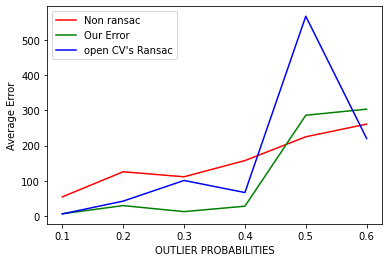

In [ ]:
plt.plot(np.arange(0.1,0.7,0.1),nonransac_err_list,label="Non ransac",color="red")
plt.plot(np.arange(0.1,0.7,0.1),our_err_list,label="Our Error",color="green")
plt.plot(np.arange(0.1,0.7,0.1),cv_ransac_err_list,label="open CV's Ransac",color="blue")
plt.legend()
plt.xlabel("OUTLIER PROBABILITIES")
plt.ylabel("Average Error")
plt.show()

Observations: In the graph, Our algorithm has lower error for lower value of Outlier Probability, after 0.5 Open CVs Ransac has lower error.

